# Setup

In [1]:
import pandas as pd
import polars as pl 
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from tools import preprocess, get_corpus_list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (confusion_matrix)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_d

In [2]:
data = pl.read_csv("./dataset.csv")

In [3]:
data.head()

app_id,app_name,review_text,review_score,review_votes
i64,str,str,i64,i64
10,"""Counter-Strike""","""Ruined my life.""",1,0
10,"""Counter-Strike""","""This will be more of a ''my ex…",1,1
10,"""Counter-Strike""","""This game saved my virginity.""",1,0
10,"""Counter-Strike""","""• Do you like original games? …",1,0
10,"""Counter-Strike""",""" Easy to learn, hard to…",1,1


In [4]:
data.shape

(6417106, 5)

In [5]:
data["review_score"].value_counts()["review_score"]

review_score
i64
-1
1


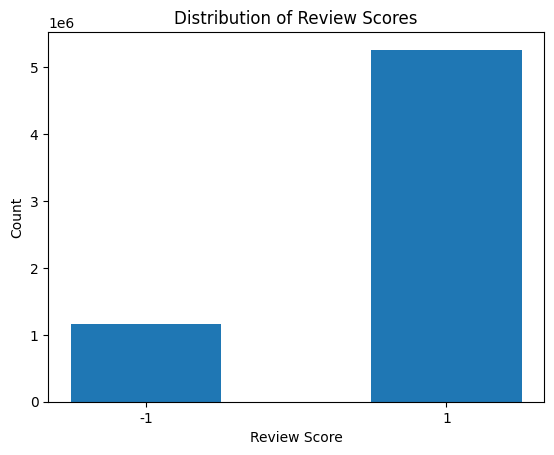

In [6]:
value_counts = data["review_score"].value_counts()
cols = value_counts["review_score"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.5)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

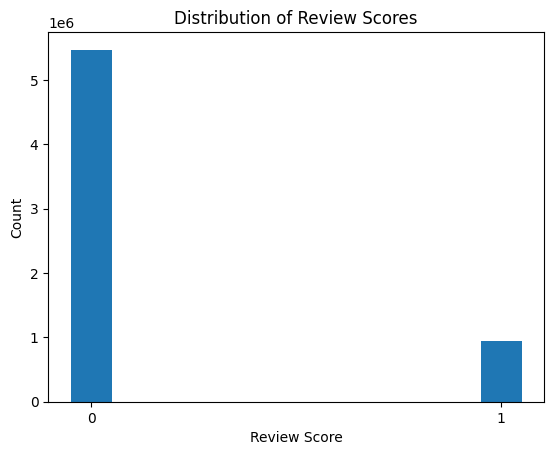

In [7]:
value_counts = data["review_votes"].value_counts()
cols = value_counts["review_votes"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.1)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

# Tien xu ly du lieu

In [8]:
data.null_count()

app_id,app_name,review_text,review_score,review_votes
u32,u32,u32,u32,u32
0,183234,7305,0,0


In [9]:
data.null_count()*100/len(data)

app_id,app_name,review_text,review_score,review_votes
f64,f64,f64,f64,f64
0.0,2.855399,0.113836,0.0,0.0


In [10]:
data["review_text"].null_count()/len(data)

0.0011383636174936177

In [11]:
data = data[:, ["review_text", "review_votes"]]

In [12]:
data = data.drop_nulls()

In [13]:
data.null_count()*100/len(data)

review_text,review_votes
f64,f64
0.0,0.0


In [14]:
data = data.unique()

In [15]:
data.shape

(4483987, 2)

## Chon du lieu nho hon

In [44]:
n_sample = 2500

In [45]:
# Tron du lieu dam bao tinh ngau nhien
shuffled_data = data.sample(fraction=1, shuffle=True, seed=42)

In [46]:
# Lay n phan tu cua tieu cuc
votes_0 = shuffled_data.filter(pl.col("review_votes") == 0)
votes_0 = votes_0.head(n_sample)
votes_0.head()

review_text,review_votes
str,i64
"""8/10 Great game. Team work, a …",0
"""This game, has touched my hear…",0
"""Documents, Please""",0
"""Great game has it's bugs but d…",0
"""M:tG is the best trading card …",0


In [47]:
votes_1 = shuffled_data.filter(pl.col("review_votes") == 1)
votes_1 = votes_1.head(n_sample)
votes_1.head()

review_text,review_votes
str,i64
"""Chewed bubble gum....got radia…",1
"""well, i enjoy that game a lot.…",1
"""Math....you gotta love it....""",1
"""This game is broken and border…",1
"""When you first start the game …",1


In [48]:
small_data = pl.concat([votes_0, votes_1])
print(small_data["review_votes"].unique())
small_data.shape

shape: (2,)
Series: 'review_votes' [i64]
[
	0
	1
]


(5000, 2)

In [49]:
X = small_data["review_text"]
y = small_data["review_votes"]

In [50]:
X = preprocess(X.to_numpy())
X = get_corpus_list(X)

In [51]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [52]:
X = X.toarray()

## Chia du lieu

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, stratify=y)

# ML

## Logistic

In [54]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_pred = log_reg.predict(X_test)
log_cfs_mtx = confusion_matrix(log_pred, y_test)

<Axes: >

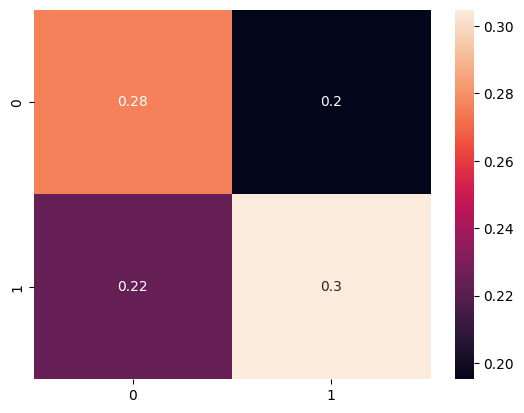

In [55]:
sns.heatmap(log_cfs_mtx/np.sum(log_cfs_mtx), annot=True)

## Naive Bayes

In [56]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

nb_pred = gaussian_nb.predict(X_test)
nb_cfs_mtx = confusion_matrix(nb_pred, y_test)

<Axes: >

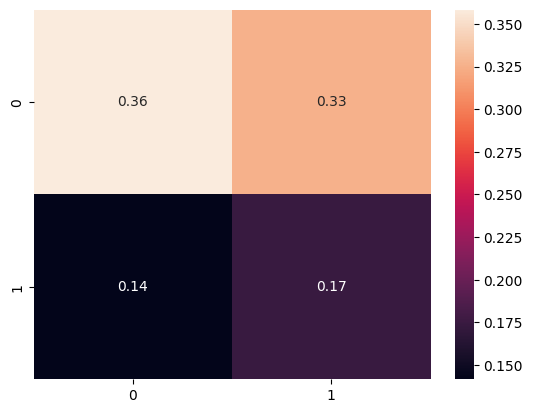

In [57]:
sns.heatmap(nb_cfs_mtx/np.sum(nb_cfs_mtx), annot=True)